In [3]:
# Imports
!pip install preliz

import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import pandas as pd


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### Context
Any given Minecraft world has a seed that is used to generate the world. That seed determines all randomness, including what biome you spawn in. While playing the game, it feels like it is disproportionately likely to spawn close to an ocean. To that end, this project aims to determine the distribution of the distance to the nearest ocean from the spawn point.

Last project, I determined that 67% were <256 blocks, while only 30% were <64 blocks. I generally expect the right end of the distribution to tail off exponentially, while the far left should more normal-like (it is unlikely to spawn in the ocean, but it is possible). The first likelihood I tested was the gamma distribution, which roughly matches that shape.  

<Axes: >

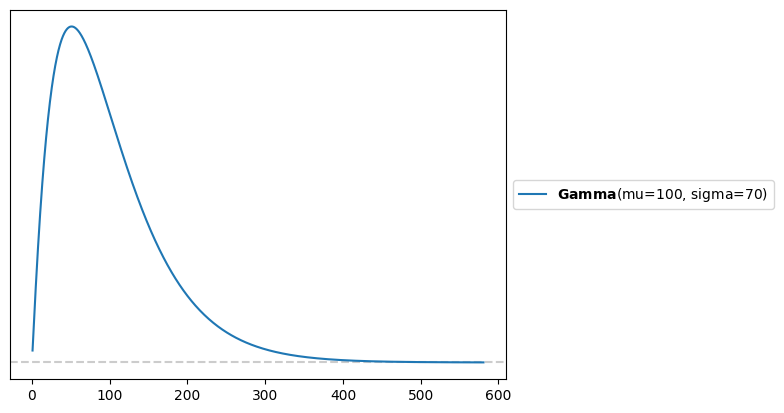

In [4]:
# This is about what I expect the likelihood to look like, informing my priors
pz.Gamma(mu=100, sigma=70).plot_pdf()

#### Data
I collected the data for 10,000 seeds by generating a world, finding the nearest ocean, and recording the distance. The data is in the file `seeds.csv`. The histogram proves my initial guesses to be relatively accurate.

Note: due to the gamma distribution being strictly positive, I had to convert all 0s to 0.0000001s. This is a hack, but shouldn't noticeably affect the results.

data max:  1991.2126958213178
data min:  0.0
data mean:  265.7009392068507
data std dev:  268.1932491778967


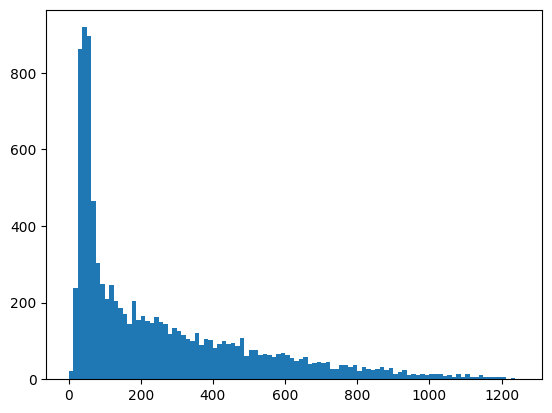

In [26]:
# Load the data, and plot a histogram to visualize it
with open("seeds.csv") as seeds:
    data = np.array([f if f != 0 else 0.0000001 for f in [float(f) for f in seeds.read().split(",")]])

plt.hist(data, bins=100, range=(0, 1250))
print("data max: ", np.max(data))
print("data min: ", np.min(data))
print("data mean: ", np.mean(data))
print("data std dev: ", np.std(data))

#### Model
Now we try the gamma model. I used gamma priors, as the mu and sigma are both positive, but likely relatively normal. I centered their means around the values I found when I visualized the expected likelihood above.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

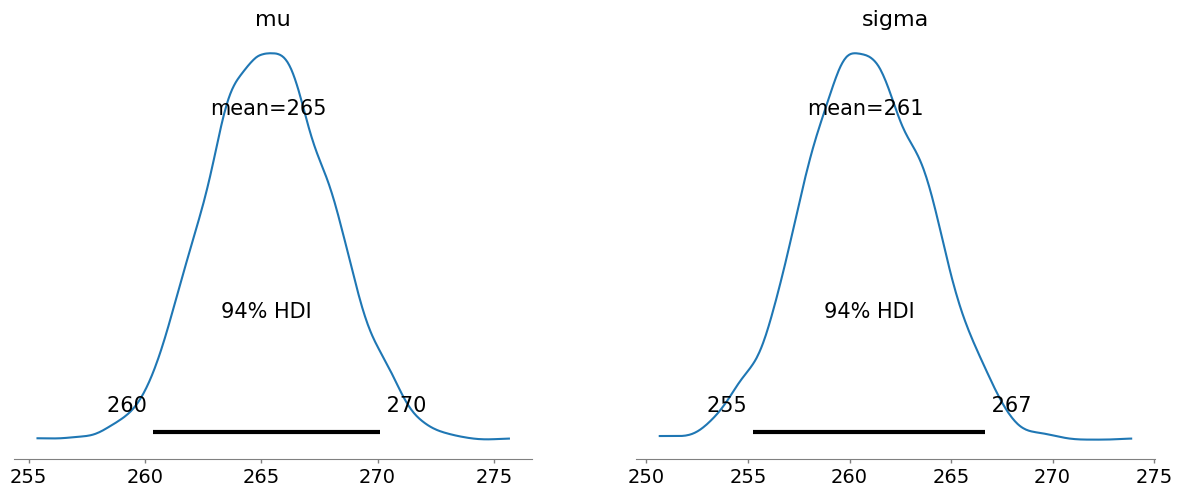

In [6]:
# Try the model
with pm.Model() as model:
    mu = pm.Gamma('mu', mu=100, sigma=50)
    sigma = pm.Gamma('sigma', mu=70, sigma=30)
    y = pm.Gamma('y', mu=mu, sigma=sigma, observed=data)

    post = pm.sample(1000)

az.plot_posterior(post)

Sampling: [y]


Output()

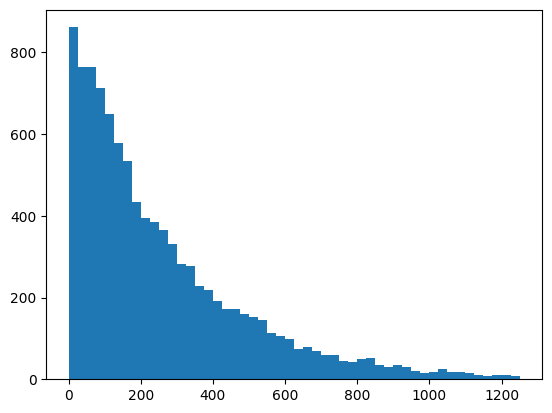

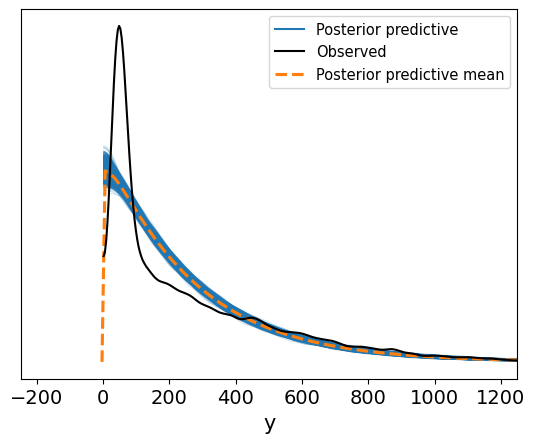

In [7]:
# Check the posterior predictive
pm.sample_posterior_predictive(post, model=model, extend_inferencedata=True)

prediction = az.extract(post, group="posterior_predictive").sel(sample=0).sel(draw=0).y.to_series().values
plt.hist(prediction, bins=50, range=(0, 1250))

az.plot_ppc(post).set_xbound(upper=1250)

#### Failure (for now)
As you can see, the posterior doesn't fit particularly well. The histogram of the predicted values is too exponential. Essentially, the model (the dashed orange line in the lower graph) can't quite capture the normal distribution on the left side of the data (the white line).

While looking for a new model, I stumbled across the ExGaussian distribution. This is a convolution of a normal and exponential distribution--a way to combine the two distributions. I think this could work well, as the normal distribution could capture the left side of the data, while the exponential could capture the right side. Below is a visualization of an ExGaussian distribution that looks as I expect the likelihood to.

<Axes: >

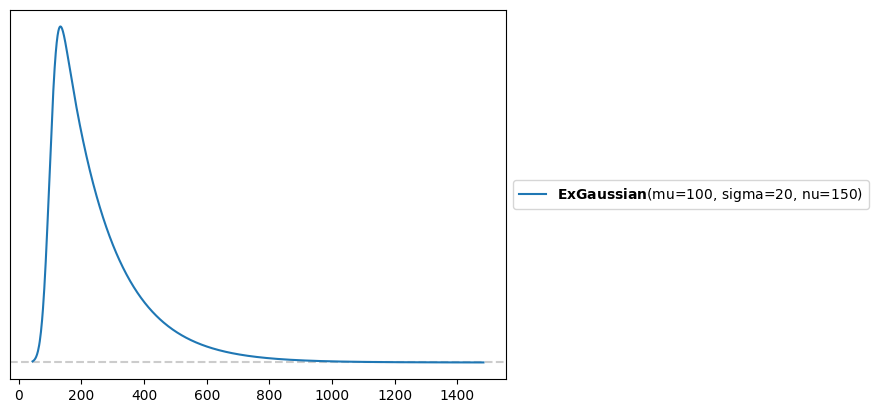

In [19]:
# Visualize what we want
pz.ExGaussian(mu=100, sigma=20, nu=150).plot_pdf()

#### ExGaussian Breakdown
This means that I expect the most common values to be around 100, and relatively clustered (std dev of 20). The beta value of the exponential makes it tail off for a long ways, allowing values of 600+ to be possible. These parameters specify a convolution of the following two distributions.

<Axes: >

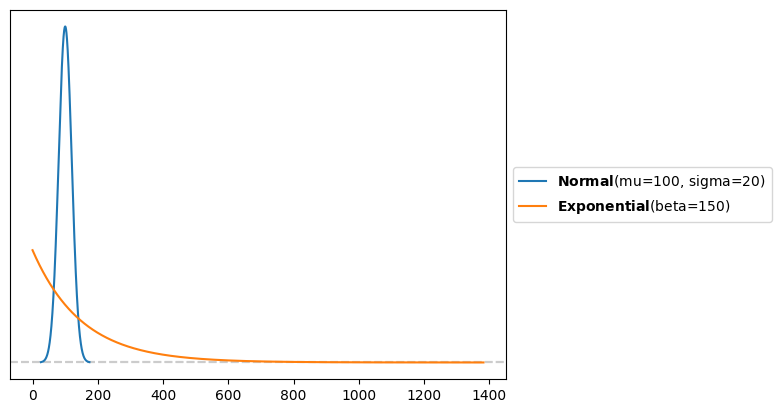

In [22]:
pz.Normal(mu=100, sigma=20).plot_pdf()
pz.Exponential(beta=150).plot_pdf()

#### Priors
Since the ExGaussian has 3 variables, we will have 3 priors. I will center the means of the priors around the values I found when I visualized the expected likelihood above. I will make them Gamma distributions so that they are relatively normal, but positive. The standard deviations are determined based on my relative confidence in the values (not very, for the most part).

<Axes: >

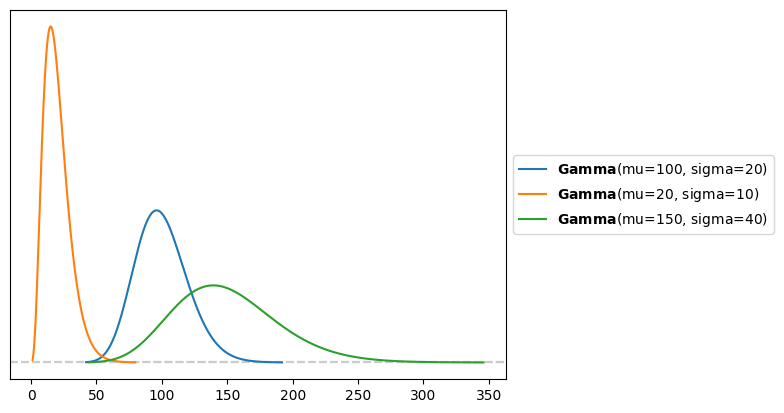

In [11]:
# Visualize the prior
pz.Gamma(mu=100, sigma=20).plot_pdf() # mu: mean of the normal
pz.Gamma(mu=20, sigma=10).plot_pdf() # sigma: std dev of the normal
pz.Gamma(mu=150, sigma=40).plot_pdf() # nu: mean of the exponential

#### Model
Now we try the ExGaussian model, with the priors as defined above, and run a post-predictive test on it.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'nu'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

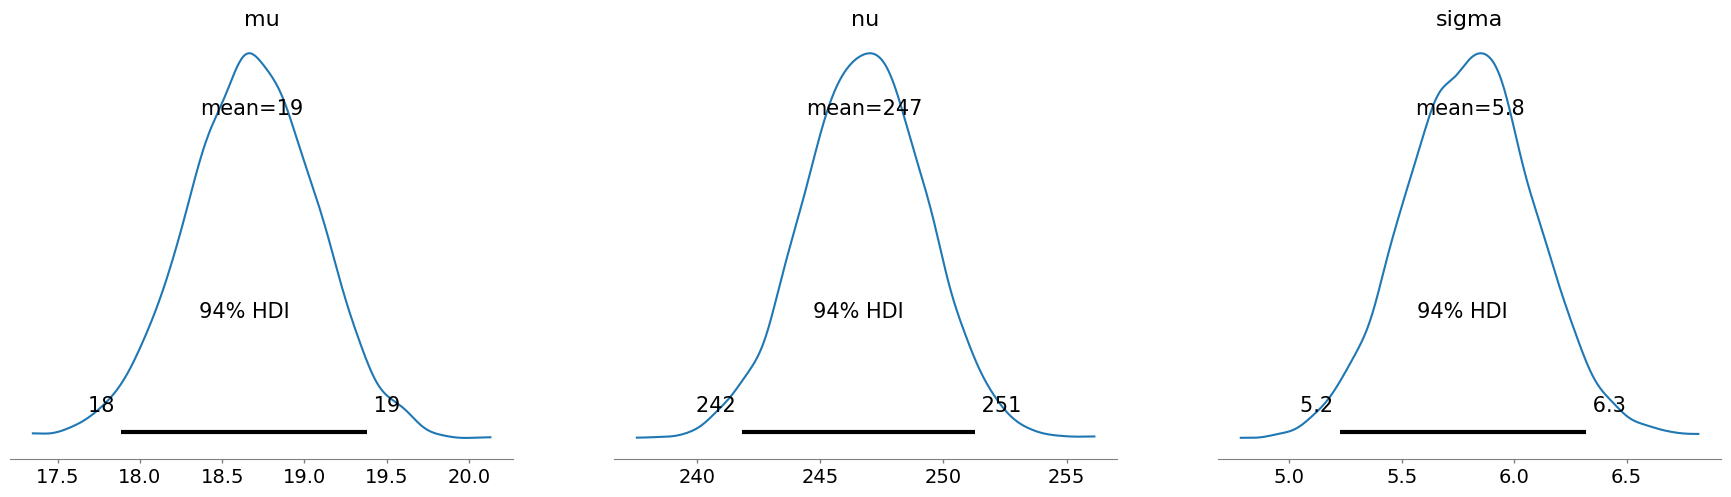

In [23]:
# Run the model
with pm.Model() as model:
    mu = pm.Gamma('mu', mu=100, sigma=20)
    sigma = pm.Gamma('sigma', mu=20, sigma=10)
    nu = pm.Gamma('nu', mu=150, sigma=40)
    y = pm.ExGaussian('y', mu=mu, sigma=sigma, nu=nu, observed=data)

    post = pm.sample(1000)

az.plot_posterior(post)

#### Posterior Analysis
We can see that the posterior does create relatively normal distributions for the ExGaussian inputs, as expected, though the values are far from anticipated. The posterior predicts the mu to be ~20 vs the expected 100, the sigma to be ~6 vs 20, and the nu to be ~247 vs 150. This means that the normal part of the ExGaussian will be much closer and narrower, and the exponential will tail off for longer. The posterior predictive test is below. The histogram graphs the predicted values (blue) along with the data (orange).

Sampling: [y]


Output()

prediction mean:  276.71284406827175
prediction std dev:  259.40566900273444


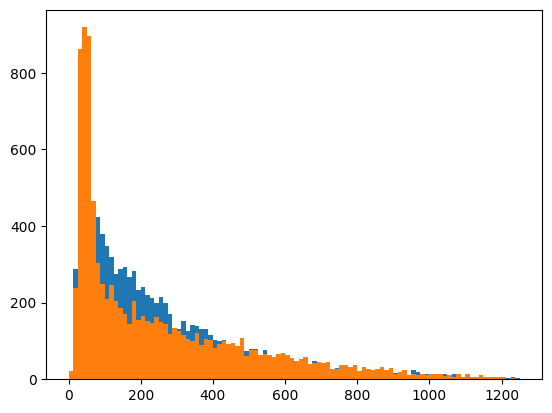

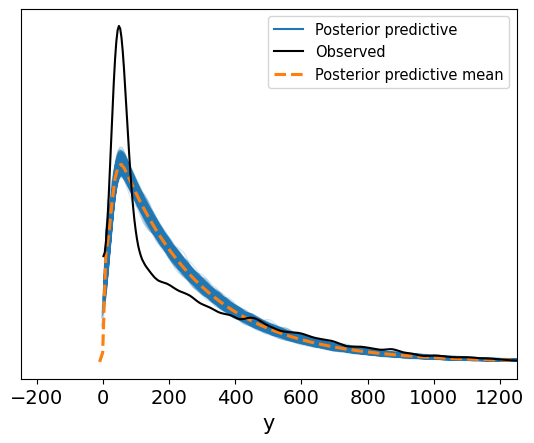

In [24]:
# Test predictive
pm.sample_posterior_predictive(post, model=model, extend_inferencedata=True)

prediction = az.extract(post, group="posterior_predictive").sel(sample=0).sel(draw=0).y.to_series().values
plt.hist(prediction, bins=100, range=(0, 1250))
plt.hist(data, bins=100, range=(0, 1250)) # put this on top to compare
print("prediction mean: ", np.mean(prediction))
print("prediction std dev: ", np.std(prediction))

az.plot_ppc(post).set_xbound(upper=1250)

#### Conclusion
The model is much better, but still can't quite capture the normal distribution on the left side. I believe that this is because the convolution is more of an average of the normal and exponential, while the data appears to change harshly from normal to exponential. This is likely because the underlying code is a mixture: it combines 5 octaves of perlin noise. To properly capture it, I will need a mixture model--no single distribution will capture it, though the ExGaussian came fairly close.